In [1]:
from init_plot import *

2024-09-15 15:45:32.506798: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[func help]----------------------------------------------------------------
> parameter
    p_root	[name] res_publish
        p_run, p_plot, p_res, p_cache, p_pdf
    p_df_varmap
    map_sp_reverse
    rng
[from func import * ]------------------------------------------------------
| p_root                  | display              | get_res_obs               |
| p_run                   | h5ad_to_mtx          | get_source_obs            |
| p_plot                  | load_adata           | get_matrix_max_prob_median|
| p_res                   | load_normalized_adata| get_matrix_count          |
| p_cache                 | pdf2_merge           | get_path_varmap           |
| p_pdf                   | show_umap            | get_res_stat              |
| p_data_process          | time_tag_detect      | find_path_from_para       |
| map_sp                  | time_tag_get         | func_help                 |
| map_sp_reverse          | time_tag_toggle      |                           |
| map_s

In [2]:
item = 'healthy'
show_legend = False

model = 'csMAHN'
if sys.argv[1] == 'True':
    model = sys.argv[2]
assert model in 'Seurat,CAME,csMAHN,SAMap'.split(
    ','), '[Error] Invalid modle "{}"'.format(model)

ppara_key = 'F1-score'
# ppara_key = 'Accuracy'


def handel_process_adata(adata):
    data = adata.obs
    data = data.rename(columns={'preobs_X_batch': 'preobs__batch'})\
        .rename(columns={'preobs__batch': 'batch'})

    data['sp'] = data['sp'].map(map_sp)

    data['model_label'] = ''
    data['model_label'] = data['model_label'].mask(
        data['dataset_type'] == 'ref', data['true_label'])
    data['model_label'] = data['model_label'].mask(data['dataset_type'] == 'que', data['pre_label'])
    adata.obs = data
    return adata


def plot_HCL_MCA_group(a4p, x, y, tissue, order_sp, cmap,
                       cmap_sp, draw_batch=True, cmap_batch=None):
    def handel_cmap_batch(keys, colors):
        res = {k: v for k, v in zip(keys, colors)}
        if len(keys) > len(colors):
            res = update_dict(pl.cmap.get(keys), res)
        return res

    # kw_scatter = dict(alpha = .5)
    kw_scatter = {}
    order_model = 'Seurat,SAMap,CAME,csMAHN'.split(',')
    with Block('item', context=dict(x=x, y=y, tissue=tissue, order_sp=order_sp)) as context:
        adatas = {m: get_adata_umap(ppara_data['res_HCL_MCA'].loc[
            '{tissue};{order_sp};{0}'.format(m, **context.context), :]) for m in order_model}
        adatas = {k: handel_process_adata(v) for k, v in adatas.items()}
        with Block('cmap'):
            cmap_sp = {k: v for k, v in zip('human,mouse'.split(','), cmap_sp)}
            cmap = {k: v for k, v in zip(np.unique(adatas['csMAHN'].obs['model_label']), cmap)}
            if draw_batch:
                cmap_batch['ref'] = handel_cmap_batch(adatas['csMAHN'].obs.query(
                    "dataset_type == 'ref'")['batch'].unique(), cmap_batch['ref'])
                cmap_batch['que'] = handel_cmap_batch(adatas['csMAHN'].obs.query(
                    "dataset_type == 'que'")['batch'].unique(), cmap_batch['que'])
                cmap_batch['all'] = update_dict(cmap_batch['ref'], cmap_batch['que'])
        with Block('cell_type'):
            df_para = ut.df.product_seq([order_model, "ref,que;ref;que;que".split(';')],
                                        'model,q'.split(','))
            df_para['key'] = np.ravel(
                np.repeat(['sp,model_label,model_label,true_label'.split(',')], 4).reshape(4, 4), order='F')
            a4p.area_update(context.x, context.y, 4, 4, 3, 3, gap_height=.25, gap_width=.25)
            for ax, (i, row) in zip(a4p.area_yield_ax(rc=pl.rc_blank), df_para.iterrows()):
                ut.sc.pl.umap(ut.sc.subset_adata(adatas[row['model']], 'dataset_type', row['q'].split(',')),
                              row['key'], ax, cmap=cmap_sp if row['key'] == 'sp' else cmap, size=.5, kw_scatter=kw_scatter)
                ax.set_rasterized(True)

            for i, (ax, title) in enumerate(zip(a4p.area_yield_ax(rc=pl.rc_blank, order='C'),
                                                'species,{sp_ref}\n(reference),{sp_que}\n(query),{sp_que}'.format(
                    sp_ref=map_sp[context.order_sp[0]], sp_que=map_sp[context.order_sp[1]]).split(','))):
                ax.set_title(title)
            for i, (ax, title) in enumerate(zip(a4p.area_yield_ax(rc=pl.rc_blank, order='F'),
                                                order_model)):
                ax.set_ylabel(title, fontsize=pl.rc_default['axes.titlesize'])

        context.x += 13.5

        with Block('batch'):
            if draw_batch:
                df_para = ut.df.product_seq(
                    [order_model, "ref;que".split(';')], 'model,q'.split(','))
                df_para['key'] = np.ravel(np.repeat(['batch,batch'.split(',')], 4), order='F')
                a4p.area_update(context.x, context.y, 4, 2, 3, 3, gap_height=.25, gap_width=.25)
                for ax, (i, row) in zip(a4p.area_yield_ax(rc=pl.rc_blank), df_para.iterrows()):
                    ut.sc.pl.umap(ut.sc.subset_adata(adatas[row['model']], 'dataset_type', row['q'].split(',')),
                                  row['key'], ax, cmap=cmap_batch['all'], size=.5, kw_scatter=kw_scatter)
                    ax.set_rasterized(True)
                for i, (ax, title) in enumerate(zip(a4p.area_yield_ax(rc=pl.rc_blank, order='C'),
                                                    'batch {sp_ref},batch {sp_que}'.format(sp_ref=map_sp[context.order_sp[0]],
                                                                                           sp_que=map_sp[context.order_sp[1]]).split(','))):
                    ax.set_title(title)
                context.x += 7

        # legend
        ax = a4p.add_ax(context.x, context.y, 1, 1)
        pl.cmap.show(cmap_sp, ax=ax, kw_scatter=kw_scatter)
        ax.set_title('species')
        context.y += 2
        ax = a4p.add_ax(context.x, context.y, 1, len(cmap.keys())*.5)
        pl.cmap.show(cmap, ax=ax, kw_scatter=kw_scatter)
        ax.set_ymargin(.1)
        ax.set_title('cell type')
        context.y += len(cmap.keys())*.5 + 2

        if draw_batch:
            a4p.area_update(context.x, context.y, 1, 2, 1,
                            max(len(cmap_batch['ref'].keys()), len(cmap_batch['que'].keys()))*.65,
                            gap_width=2.5)
            for i, (ax, k) in enumerate(zip(a4p.area_yield_ax(), 'ref,que'.split(','))):
                ax.set_title('batch {}'.format(map_sp[context.order_sp[i]]))
                pl.cmap.show(cmap_batch[k], ax=ax, kw_scatter=kw_scatter)
                ax.set_ymargin(.1)

# prepare

## HCL and MCA

In [3]:
with Block("""
ppara_data
    res_HCL_MCA
    HCL_MCA_h
    HCL_MCA_m
"""):
    with Block('res_HCL_MCA'):
        q_tissue = 'Adrenal-Gland,Bone-Marrow,Brain,Heart,Intestine,Kidney,Liver,Spleen'.split(',')
        data = get_test_result_df(p_res).query("tissue in @q_tissue")
        data = data[~data['dir'].apply(time_tag_detect)]
        data['model'] = data['model'].mask(data['model'] == 'came', 'CAME')

        data['is_1v1'] = ''
        data['is_1v1'] = data['is_1v1'].mask(
            data['resdir_tag'].str.contains('is_1v1=True'), '_1v1').mask(
                data['model'] == 'Seurat', '')
        data['model_mask'] = ut.df.apply_merge_field(data, '{model}{is_1v1}')
        data = data.drop(columns='is_1v1')
        data = data[~data['model_mask'].str.endswith('_1v1')]
        data['tissue_mask'] = data['tissue'].str.replace('-', '\n')

        data['F1-score'] = data.apply(get_res_stat, key='F1-score',
                                      q="dataset_type == 'que'", axis=1)
        data['Accuracy'] = data.apply(get_res_stat, key='Accuracy',
                                      q="dataset_type == 'que'", axis=1)
        data['__index'] = ut.df.apply_merge_field(data, '{tissue};{sp_ref}{sp_que};{model_mask}')
        data = ut.df.reindex_with_unique_col(data, '__index', drop=True)
        ppara_data['res_HCL_MCA'] = data
        del data
    with Block('HCL_MCA_h'):
        data = ppara_data['res_HCL_MCA'].query("sp_ref == 'h'")\
            .loc[:, 'tissue_mask,model_mask'.split(',')+['Accuracy', 'F1-score']]\
            .sort_values('tissue_mask,model_mask'.split(',')).copy()
        data['x'] = data['tissue_mask'].map(
            {_: i*4 for i, (_) in enumerate(data['tissue_mask'].unique())})
        ppara_data['HCL_MCA_h'] = data
        del data
    with Block('HCL_MCA_m'):
        data = ppara_data['res_HCL_MCA'].query("sp_ref == 'm'")\
            .loc[:, 'tissue_mask,model_mask'.split(',')+['Accuracy', 'F1-score']]\
            .sort_values('tissue_mask,model_mask'.split(',')).copy()
        data['x'] = data['tissue_mask'].map(
            {_: i*4 for i, (_) in enumerate(data['tissue_mask'].unique())})
        ppara_data['HCL_MCA_m'] = data
        del data
# 3182BD,#E6550D,#31A354,#756BB1
with Block("ppara_cmap"):
    ppara_cmap['HCL_MCA_model_mask'] = {k: v
                                        for k, v in zip(
                                            'Seurat,SAMap,CAME,csMAHN'.split(','),
                                            # '#67C1EC,#2DABB2,#DAAB36,#F0552B'.split(',')
                                            '#6BAED6,#756BB1,#31A354,#E6550D'.split(',')
                                        )
                                        }
    ppara_cmap['retina_model'] = subset_dict(
        ppara_cmap['HCL_MCA_model_mask'],
        'SAMap,CAME,csMAHN'.split(','))


with Block("ppara_func['scatter_model']"):
    def _func(df_plot, key, ax):
        for model_mask, marker in zip('Seurat,SAMap,CAME,csMAHN'.split(','), 'o,h,p,v'.split(',')):
            _plot = df_plot.query("model_mask == '{}'".format(model_mask))
            ax.scatter(
                _plot['x'],
                _plot[key],
                label=model_mask,
                s=20,
                marker=marker,
                color=ppara_cmap['HCL_MCA_model_mask'][model_mask])
        ax.set_yticks(
            np.linspace(
                0, 1, 6), [
                '{:.1f}'.format(_) for _ in np.linspace(
                    0, 1, 6)], **fontdict_default)
        ax.set_xticks(
            df_plot.drop_duplicates(
                'tissue_mask,x'.split(','))['x'],
            df_plot.drop_duplicates(
                'tissue_mask,x'.split(','))['tissue_mask'],
            **pl.tl_fontdict('ctc'))
        ax.set_ylabel('weighted {}'.format(key) if key ==
                      'F1-score' else key, fontdict=fontdict_default)

    ppara_func['scatter_model'] = _func
    del _func


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$


/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/pandas/core/strings/accessor.py:2738: FutureWarning: Possible nested set at position 127
  regex = re.compile(pat, flags=flags)


## retina

In [4]:
with Block("""
ppara_data
    res_retina
    retina_F1-score
    retina_Accuracy
"""):
    with Block('res_retina'):
        data = get_test_result_df(p_res)
        data['model'] = data['model'].mask(data['model'] == 'came', 'CAME')
        data = data.query("tissue == 'retina'")
        data = data[~data['dir'].apply(time_tag_detect)]
        data['is_1v1'] = ''
        data['is_1v1'] = data['is_1v1'].mask(
            data['resdir_tag'].str.contains('is_1v1=True'), '_1v1').mask(
                data['model'] == 'Seurat', '')
        data['model_mask'] = ut.df.apply_merge_field(data, '{model}{is_1v1}')
        data = data.drop(columns='is_1v1')
        data['F1-score'] = data.apply(get_res_stat, key='F1-score',
                                      q="dataset_type == 'que'", axis=1)
        data['Accuracy'] = data.apply(
            get_res_stat,
            key='Accuracy',
            q="dataset_type == 'que'",
            axis=1)

        data['parameter_hvg_deg'] = data['resdir_tag'].str.extract(
            '(n_hvgs=\\d+;n_degs=\\d+)', expand=False).fillna('')
        data = data[data['parameter_hvg_deg'].str.len() == 0]

        data['__index'] = ut.df.apply_merge_field(data, '{tissue};{sp_ref}{sp_que};{model_mask}')
        data = ut.df.reindex_with_unique_col(data, '__index', drop=True)
        ppara_data['res_retina'] = data
        del data

    ppara_data['retina_Accuracy'] = ppara_data['res_retina']\
        .pivot(values='Accuracy', index='model_mask', columns='sp_que')\
        .rename(columns=map_sp)

    ppara_data['retina_F1-score'] = ppara_data['res_retina']\
        .pivot(values='F1-score', index='model_mask', columns='sp_que')\
        .rename(columns=map_sp)

with Block("ppara_func['retina_line_one2one']"):
    def _func(df_plot, key, ax, color_map, del_ytick=False):
        # line of Seurat
        ax.hlines(df_plot['Seurat'], 0.6, 2.4, linestyles=':', linewidth=1,
                  colors='black')
        ax.text(.8, df_plot['Seurat'] - .1, 'Seurat', fontdict=fontdict_default)
        ax.set_title(df_plot.name)
        for k, v in color_map.items():
            ax.plot([1, 2], [df_plot['{}_1v1'.format(k)], df_plot[k]],
                    label=k, color=v, marker='.')

        ax.set_xlim(0.5, 2.5)
        ax.set_ylim(0, 1.1)
        ax.set_xticks([1, 2], 'one\nto one,append many\nand one\nto many'.split(
            ','), **pl.tl_fontdict('ctc', fontsize=6))
        if del_ytick:
            ax.set_yticks([], [])
        else:
            ax.set_yticks(np.linspace(0, 1, 6), ['{:.1f}'.format(_)
                          for _ in np.linspace(0, 1, 6)], **fontdict_default)
            ax.set_ylabel(
                'weighted {}'.format(key) if key == 'F1-score' else key,
                fontdict=fontdict_default)
        ax.tick_params('y', which='both', length=2)
        ax.tick_params('x', which='both', length=1)

    ppara_func['retina_line_one2one'] = _func
    del _func


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$


## retina-p

In [5]:
with Block("ppara_data"):

    with Block("res_retina-p"):
        data = get_test_result_df(p_res)
        data['model'] = data['model'].mask(data['model'] == 'came', 'CAME')
        data = data.query("tissue == 'retina-p'").query("sp_ref == 'z'")
        data['is_1v1'] = ''
        data['is_1v1'] = data['is_1v1'].mask(
            data['resdir_tag'].str.contains('is_1v1=True'), '_1v1').mask(
                data['model'] == 'Seurat', '')
        data['model_mask'] = data.apply(lambda _: '{model}{is_1v1}'.format(
            **_), axis=1)
        data['F1-score'] = data.apply(get_res_stat,
                                      key='F1-score',
                                      q="dataset_type == 'que'",
                                      axis=1)
        data['Accuracy'] = data.apply(
            get_res_stat,
            key='Accuracy',
            q="dataset_type == 'que'",
            axis=1)

        data['time_tag'] = data['name'].str.extract(
            ';(\\d{6}-\\d{4})$', expand=False).fillna('')
        data = data[data['time_tag'].str.len() == 0]
        data = data.drop(columns=['time_tag'])

        data['parameter_hvg_deg'] = data['resdir_tag'].str.extract(
            '(n_hvgs=\\d+;n_degs=\\d+)', expand=False).fillna('')
        data['parameter_nfeats_hidden'] = data['resdir_tag'].str.extract(
            '(nfeats=\\d+;hidden=\\d+)', expand=False).fillna('')

        ppara_data['res_retina-p'] = data

        # Seurat
        ppara_data['retina-p_Seurat_Accuracy'] = {map_sp[row['sp_que']]: row['Accuracy']
                                                  for i, row in data.query("model =='Seurat'").iterrows()}

        ppara_data['retina-p_Seurat_F1-score'] = {map_sp[row['sp_que']]: row['F1-score']
                                                  for i, row in data.query("model =='Seurat'").iterrows()}

        del data
    with Block("retina-p_hvg_deg_F1-score"):
        data = ppara_data['res_retina-p']
        data = data[data['parameter_hvg_deg'].str.len() > 0].copy()
        data['__index'] = ut.df.apply_merge_field(
            data, '{tissue};{sp_ref}{sp_que};{model_mask};{parameter_hvg_deg}')
        data = ut.df.reindex_with_unique_col(data, '__index', drop=True)
        data = data.pivot(index='parameter_hvg_deg', columns='sp_que', values='F1-score')
        data.columns = data.columns.map(map_sp)
        ppara_data['retina-p_hvg_deg_F1-score'] = data
        del data

    with Block("retina-p_nfeats_hidden_F1-score"):
        data = ppara_data['res_retina-p']
        data = data[data['parameter_nfeats_hidden'].str.len() > 0].copy()
        data['__index'] = ut.df.apply_merge_field(
            data, '{tissue};{sp_ref}{sp_que};{model_mask};{parameter_nfeats_hidden}')
        data = ut.df.reindex_with_unique_col(data, '__index', drop=True)
        data = data.pivot(index='parameter_nfeats_hidden', columns='sp_que', values='F1-score')
        data.columns = data.columns.map(map_sp)
        ppara_data['retina-p_nfeats_hidden_F1-score'] = data
        del data

ppara_cmap['retina-p_sp_que'] = {'chicken': '#FB8D62', 'human': '#8DA0CD', 'mouse': '#66C2A5'}

with Block("ppara_func['retina-p_box_scatter']"):
    def _func(df_plot,  key, color_map, dict_Seurat, ax):
        _l2d_style = {'color': 'grey', 'alpha': .5}
        ax.boxplot(
            df_plot.to_numpy(),
            positions=np.arange(3),
            boxprops=_l2d_style, capprops=_l2d_style,
            whiskerprops=_l2d_style,
            widths=.55, sym='.'
        )
        for _i, (_sp_que) in enumerate(df_plot.columns):
            ax.scatter(
                np.repeat(
                    _i,
                    df_plot[_sp_que].size) + (
                    rng.random(
                        size=df_plot[_sp_que].size) - 0.5)/3,
                df_plot[_sp_que],
                color=color_map[_sp_que],
                s=5)
            # Seurat
            ax.scatter(
                _i,
                dict_Seurat[_sp_que],
                s=10,
                marker='D',
                color='#9C9C9C')
        ax.set_ylim(0, 1)
        ax.set_yticks(
            np.linspace(
                0, 1, 6), [
                '{:.1f}'.format(_) for _ in np.linspace(
                    0, 1, 6)], **fontdict_default)
        ax.set_ylabel('weighted {}'.format(key) if key ==
                      'F1-score' else key, **fontdict_default)
        ax.set_xticks(np.arange(3), df_plot.columns, **fontdict_default)

    ppara_func['retina-p_box_scatter'] = _func
    del _func


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$


In [6]:
for i in 'retina-p_hvg_deg_F1-score,retina-p_nfeats_hidden_F1-score'.split(
        ','):
    print('[has nan] [{}] {}'.format(ppara_data[i].isna().any().any(), i))

display(
    ppara_data['retina-p_hvg_deg_F1-score'].style.highlight_null()
    .background_gradient(cmap=cm, vmin=.5, vmax=.9),
    ppara_data['retina-p_nfeats_hidden_F1-score'].style.highlight_null()
    .background_gradient(cmap=cm, vmin=.5, vmax=.9)
)

[has nan] [False] retina-p_hvg_deg_F1-score
[has nan] [False] retina-p_nfeats_hidden_F1-score


sp_que,chicken,human,mouse
parameter_hvg_deg,,,
n_hvgs=1000;n_degs=100,0.928917,0.926899,0.855093
n_hvgs=1000;n_degs=50,0.877305,0.896133,0.916034
n_hvgs=2000;n_degs=100,0.916014,0.961013,0.913441
n_hvgs=2000;n_degs=50,0.927372,0.925079,0.900346
n_hvgs=3000;n_degs=100,0.941165,0.948866,0.941811
n_hvgs=3000;n_degs=50,0.857842,0.874950,0.914383


sp_que,chicken,human,mouse
parameter_nfeats_hidden,,,
nfeats=128;hidden=64,0.860349,0.910920,0.932434
nfeats=32;hidden=64,0.872825,0.881373,0.891891
nfeats=64;hidden=128,0.907731,0.952881,0.898121
nfeats=64;hidden=32,0.881438,0.910436,0.848776
nfeats=64;hidden=64,0.897320,0.954130,0.899008


In [7]:
print(','.join(pl.cmap.ggsci.get_colors('D3-category20c')))
pl.cmap.ggsci.show()

#3182BD,#E6550D,#31A354,#756BB1,#636363,#6BAED6,#FD8D3C,#74C476,#9E9AC8,#969696,#9ECAE1,#FDAE6B,#A1D99B,#BCBDDC,#BDBDBD,#C6DBEF,#FDD0A2,#C7E9C0,#DADAEB,#D9D9D9


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39,c40,c41,c42,c43,c44,c45,c46,c47,c48,c49,c50
NPG-nrc,#E64B35,#4DBBD5,#00A087,#3C5488,#F39B7F,#8491B4,#91D1C2,#DC0000,#7E6148,#B09C85,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white
AAAS,#3B4992,#EE0000,#008B45,#631879,#008280,#BB0021,#5F559B,#A20056,#808180,#1B1919,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white
NEJM,#BC3C29,#0072B5,#E18727,#20854E,#7876B1,#6F99AD,#FFDC91,#EE4C97,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white
Lancet-lanonc,#00468B,#ED0000,#42B540,#0099B4,#925E9F,#FDAF91,#AD002A,#ADB6B6,#1B1919,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white
JAMA,#374E55,#DF8F44,#00A1D5,#B24745,#79AF97,#6A6599,#80796B,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white
BMJ,#2A6EBB,#F0AB00,#C50084,#7D5CC6,#E37222,#69BE28,#00B2A9,#CD202C,#747678,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white
JCO,#0073C2,#EFC000,#868686,#CD534C,#7AA6DC,#003C67,#8F7700,#3B3B3B,#A73030,#4A6990,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white
UCSCGB,#FF0000,#FF9900,#FFCC00,#00FF00,#6699FF,#CC33FF,#99991E,#999999,#FF00CC,#CC0000,#FFCCCC,#FFFF00,#CCFF00,#358000,#0000CC,#99CCFF,#00FFFF,#CCFFFF,#9900CC,#CC99FF,#996600,#666600,#666666,#CCCCCC,#79CC3D,#CCCC99,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white
D3-category10,#1F77B4,#FF7F0E,#2CA02C,#D62728,#9467BD,#8C564B,#E377C2,#7F7F7F,#BCBD22,#17BECF,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white
D3-category20,#1F77B4,#FF7F0E,#2CA02C,#D62728,#9467BD,#8C564B,#E377C2,#7F7F7F,#BCBD22,#17BECF,#AEC7E8,#FFBB78,#98DF8A,#FF9896,#C5B0D5,#C49C94,#F7B6D2,#C7C7C7,#DBDB8D,#9EDAE5,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white,white


### plot

[out][plot] healthy.svg 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
[out][plot] healthy.png 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
***************************************************************************
(A) csMAHN performed well on weighted-F1 score compared to Seurat, SAMap and
came on 8 tissues of HCL and MCA. human as reference and mouse as query (left
panel). mouse as reference and human as query (left panel). (B) The UMAP
plot of embeddings outputted by brain ,applied with Seurat,SAMap,CAME and
csMAHN, mouse as reference and colored with species and cell type (C) Weighted-F1
score of csMAHN is improved after appending the homology information
of one2many and many2many to the model on three pairs of cross-species scRNA-seq
data sets about the retina with zebrafish as the reference and with
chick, mouse, and human as the queries. (D) The performance of csMAHN under
different hyperparameters is stable and robust. exchange hyperparameters,


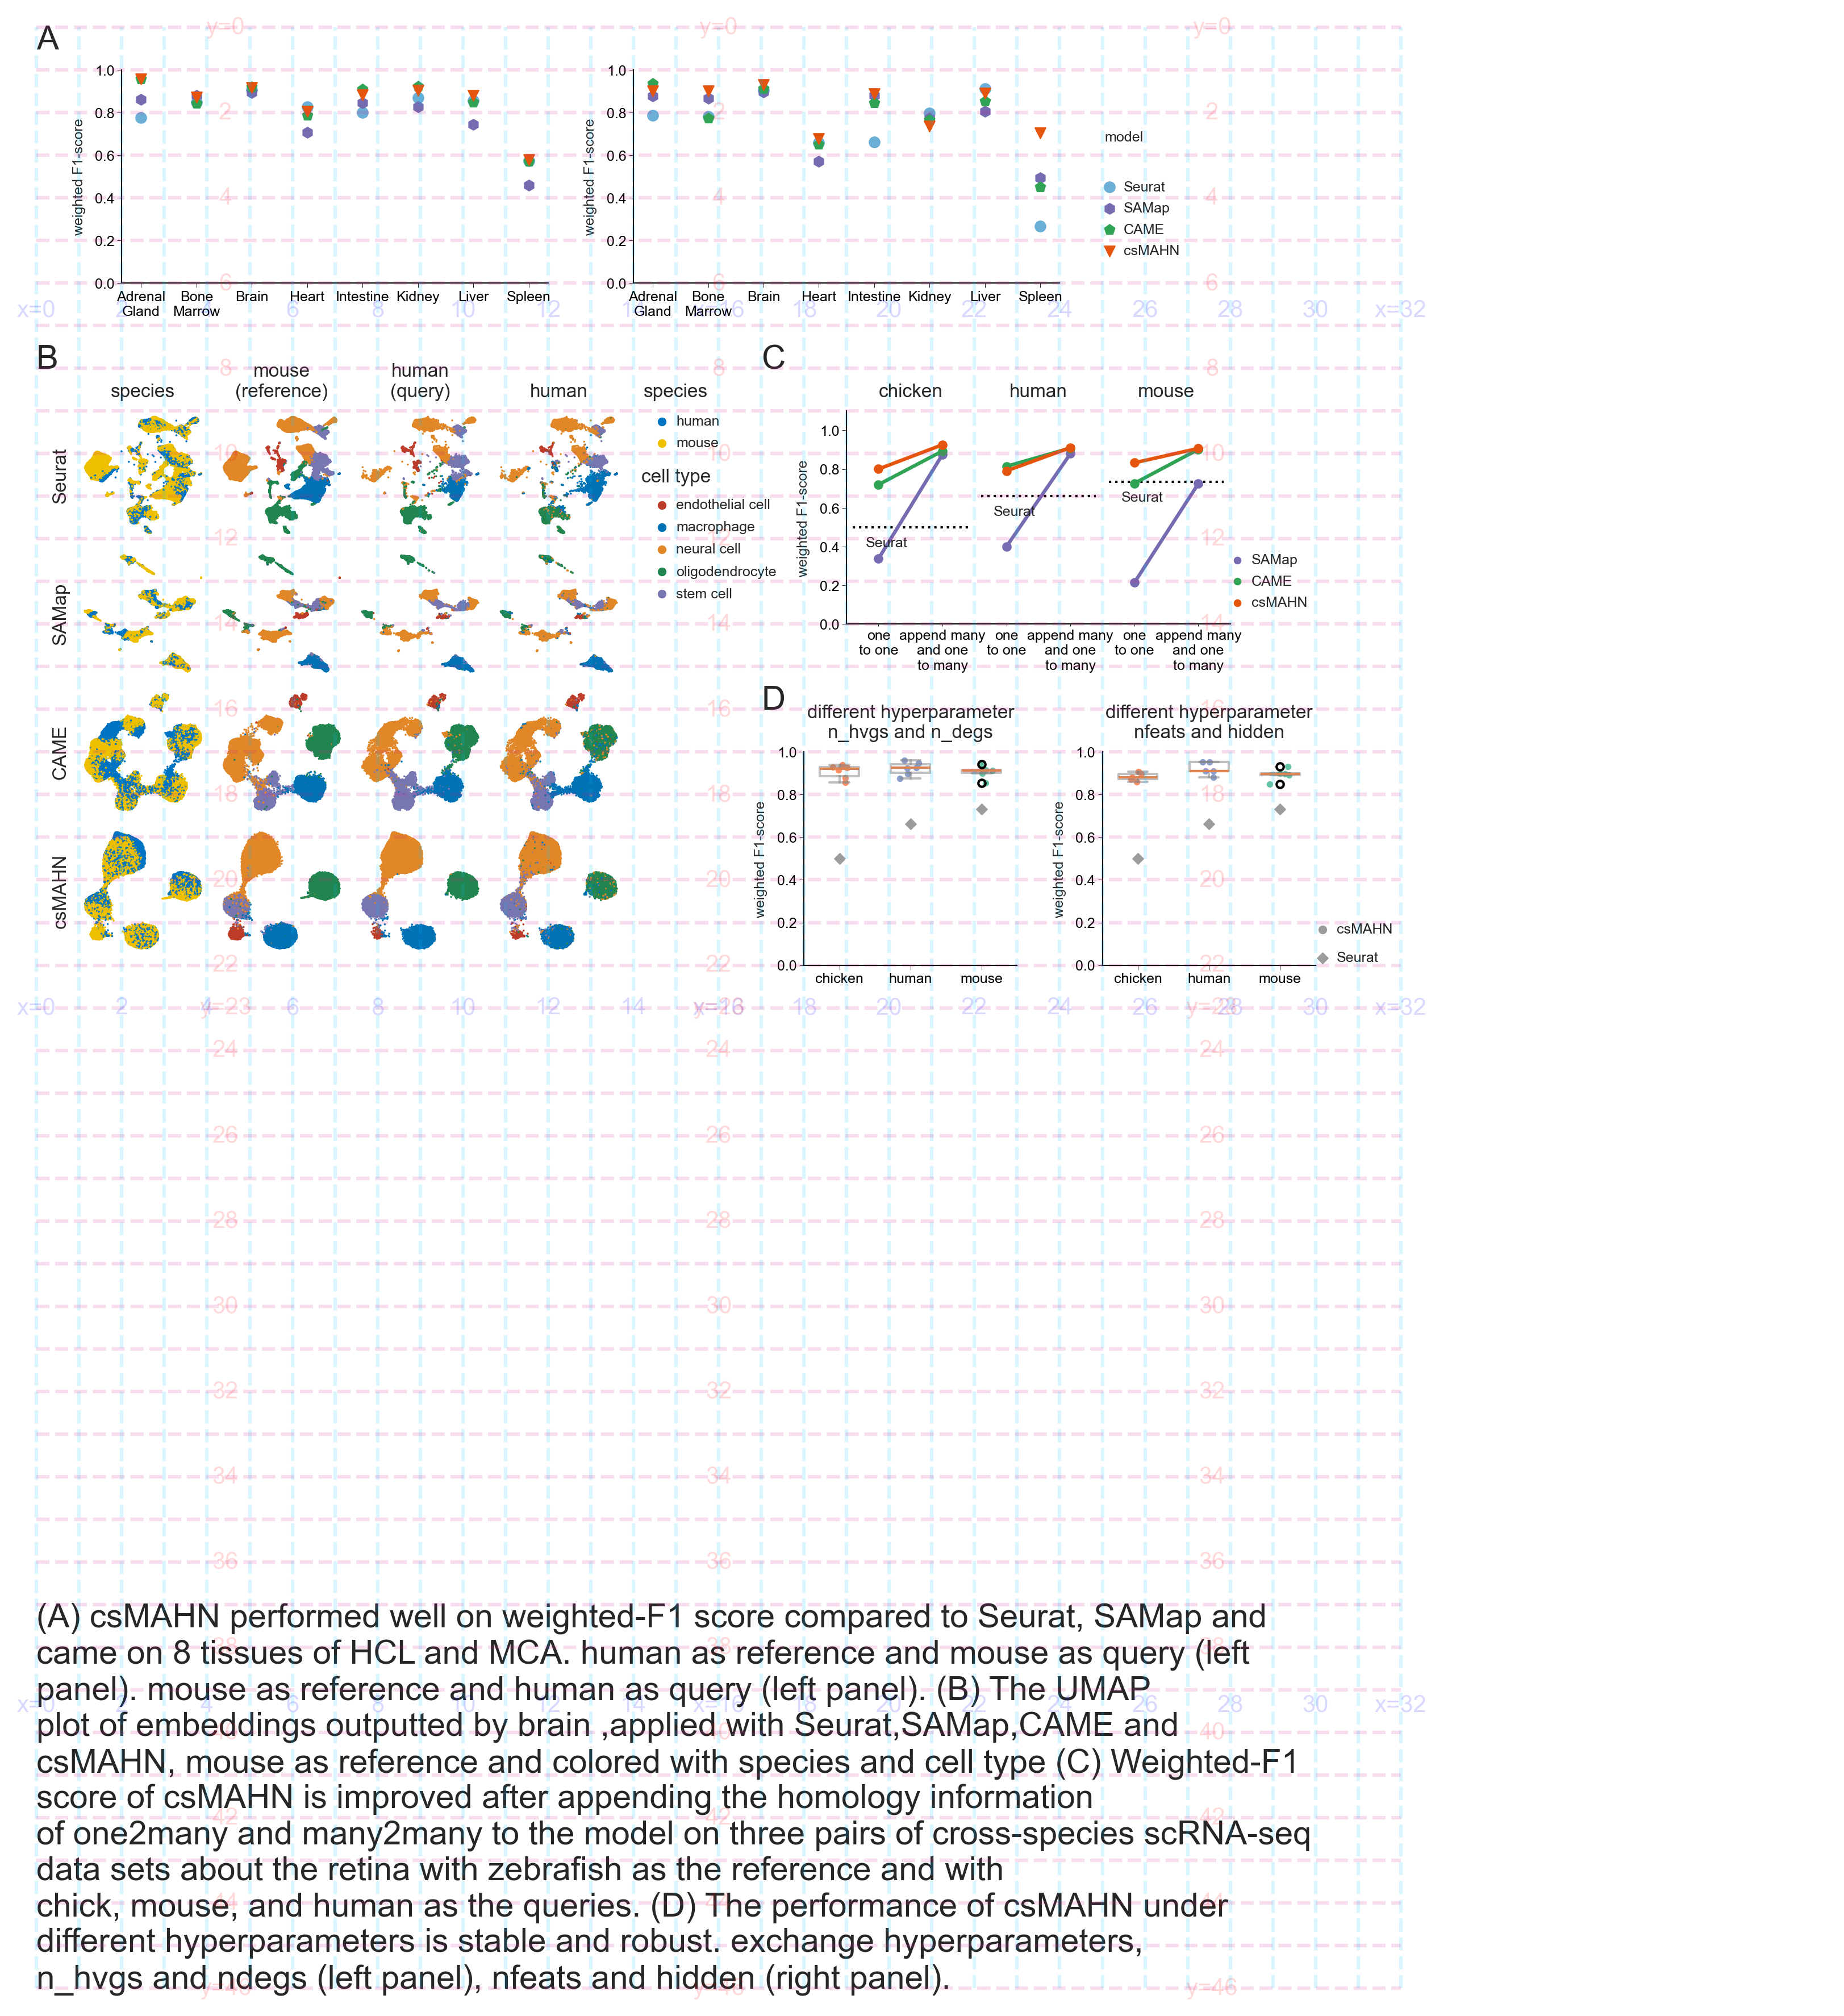

In [8]:
plt.close("all")
a4p = pl.figure.A4Page()

y = 1
with Block("scatter_model", context=dict(x=2, y=y)) as context:
    ax = a4p.add_ax(context.x, context.y, 10, 5, rc=pl.rc_frame)
    ppara_func['scatter_model'](
        ppara_data['HCL_MCA_h'], ppara_key, ax)
    ax = a4p.add_ax(context.x+12, context.y, 10, 5, rc=pl.rc_frame)
    ppara_func['scatter_model'](
        ppara_data['HCL_MCA_m'], ppara_key, ax)

    ax = a4p.add_ax(context.x+23, context.y+2, 1, 3)
    pl.cmap.show(
        ppara_cmap['HCL_MCA_model_mask'],
        ax=ax,
        size=20,
        marker='o,h,p,v'.split(','),
        fontdict=fontdict_default)
    ax.set_title('model', fontdict=fontdict_default)
y += 8

with Block('Brain mh', context=dict(x=1, y=y, tissue='Brain', order_sp='mh')) as context:
    plot_HCL_MCA_group(a4p, x=context.x, y=context.y, tissue=context.tissue, order_sp=context.order_sp,
                       cmap_sp=pl.cmap.ggsci.get_colors('JCO'),
                       cmap=pl.cmap.ggsci.get_colors('NEJM'),
                       draw_batch=False)

with Block("retina", context=dict(x=19, y=y)) as context:
    for _i, ((_, _plot)) in enumerate(
            ppara_data['retina_{}'.format(ppara_key)].items()):
        ax = a4p.add_ax(context.x+_i*3,
                        context.y,
                        3,
                        5,
                        rc=pl.tl_rc(pl.rc_frame,
                                    **{"axes.spines.left": _i == 0}))
        ppara_func['retina_line_one2one'](
            _plot, ppara_key, ax, ppara_cmap['retina_model'], del_ytick=_i > 0)
    ax = a4p.add_ax(context.x+9, context.y+3, 1, 2)
    pl.cmap.show(ppara_cmap['retina_model'], ax=ax,
                 size=30, fontdict=fontdict_default)
    ax.set_ymargin(.5)

with Block("retina-p_box_scatter", context=dict(x=18, y=y + 8)) as context:
    ax = a4p.add_ax(context.x, context.y, 5, 5, rc=pl.rc_frame)
    ppara_func['retina-p_box_scatter'](
        ppara_data['retina-p_hvg_deg_{}'.format(ppara_key)], ppara_key,
        ppara_cmap['retina-p_sp_que'],
        ppara_data['retina-p_Seurat_{}'.format(ppara_key)], ax)
    ax.set_title('different hyperparameter\nn_hvgs and n_degs')
    ax = a4p.add_ax(context.x+7, context.y, 5, 5, rc=pl.rc_frame)
    ppara_func['retina-p_box_scatter'](
        ppara_data['retina-p_nfeats_hidden_{}'.format(ppara_key)], ppara_key,
        ppara_cmap['retina-p_sp_que'],
        ppara_data['retina-p_Seurat_{}'.format(ppara_key)], ax)
    ax.set_title('different hyperparameter\nnfeats and hidden')
    # legend
    ax = a4p.add_ax(context.x+12, context.y+4)
    pl.cmap.show(
        {'csMAHN': '#9C9C9C', 'Seurat': '#9C9C9C'},
        marker=['o', 'D'], size=10, ax=ax)
    ax.set_ymargin(.25)

# text ----------------------------------------
with Block('text'):
    for text, (x, y) in zip(
            [chr(65+i) for i in range(26)], np.array([
                [0, .5], [0, 8], [17, 8], [17, 16]
            ])):
        a4p.add_text_with_ax(a4p.add_ax(x, y), text)
    del text, x, y

pl.tl_savefig(a4p.fig, 'healthy.svg', p_pdf)
pl.tl_savefig(a4p.fig, 'healthy.png', p_pdf)

with Block("note"):
    text = "\
(A) csMAHN performed well on weighted-F1 score compared to Seurat, SAMap and came on 8 tissues of HCL and MCA. human as reference and mouse as query (left panel). mouse as reference and human as query (left panel). \
(B) The UMAP plot of embeddings outputted by brain ,applied with Seurat,SAMap,CAME and csMAHN, mouse as reference and colored with species and cell type \
(C) Weighted-F1 score of csMAHN is improved after appending the homology information of one2many and many2many to the model on three pairs of cross-species scRNA-seq data sets about the retina with zebrafish as the reference and with chick, mouse, and human as the queries. \
(D) The performance of csMAHN under different hyperparameters is stable and robust. exchange hyperparameters, n_hvgs and ndegs (left panel), nfeats and hidden (right panel). \
"
    text = pl.tl_str_next_line(text, 75, ' ')
    a4p.add_text_with_ax(a4p.add_ax(0, 45, 42), text, 0, 0)
    print("{1}\n{0}\n{1}".format(text, '*'*75))
    del text

a4p.save_as_pdf(p_pdf.joinpath('healthy.pdf'))
a4p.add_grid()
a4p.fig

# supp

In [9]:
with Block("ppara_data['homo_type_count']"):
    def _func_get_homo_type_count(sp_ref, sp_que):
        df_varmap = pd.read_csv(
            get_path_varmap(
                sp_ref,
                sp_que),
            index_col=False)
        df_varmap.columns = 'ref,que,type'.split(',')
        return df_varmap['type'].value_counts().to_frame(
            name='{}\nmap {}'.format(sp_ref, sp_que)).transpose()

    df_plot = pd.concat([
        _func_get_homo_type_count('zebrafish', 'chicken'),
        _func_get_homo_type_count('zebrafish', 'mouse'),
        _func_get_homo_type_count('zebrafish', 'human'),
        _func_get_homo_type_count('mouse', 'human'),
    ], axis=0)
    df_plot = df_plot.transpose()/df_plot.sum(axis=1)
    df_plot = df_plot.pipe(pl.bar_cumsum_df_plot)\
        .pipe(pl.bar_transpose_df_cumsum)
    ppara_data['homo_type_count'] = df_plot

    ppara_cmap['homo_type'] = {
        k: v for k,
        v in zip(
            df_plot.filter(
                regex='^(?!bottom_)').columns,
            '#D77186,#61A2DA,#6CB7DA'.split(','))}

    del _func_get_homo_type_count, df_plot

In [10]:
with Block("""
ppara_data
    order_tissue
"""):
    ppara_data['order_tissue'] = np.unique(ppara_data['res_HCL_MCA']['tissue'])

In [11]:
update = False
df_para = ut.df.product_seq(
    ['hm,mh'.split(','), ppara_data['order_tissue']], 'order_sp,tissue'.split(','))
df_para['y'] = np.arange(df_para.shape[0]) % 3 * 15 + 1.5
df_para['p'] = np.arange(df_para.shape[0])//3
df_para.index = df_para.index
display(df_para)
for p in df_para['p'].unique():
    plt.close("all")
    a4p = pl.figure.A4Page()
    p_out = p_pdf.joinpath('healthy_supp_item_{}.pdf'.format(p))
    if not update and p_out.exists():
        print('[exists] {}'.format(p_out.name))
        continue
    for i, row in df_para.query("p == {}".format(p)).iterrows():
        with Block('item', context=dict(x=1, y=row['y'], tissue=row['tissue'], order_sp=row['order_sp'])) as context:
            a4p.add_text_with_ax(a4p.add_ax(context.x, context.y), chr(65+i))
            a4p.add_text_with_ax(a4p.add_ax(context.x, context.y+1), context.tissue,
                                 fontdict=pl.tl_fontdict('cc', fontsize=8))
            context.x += 2
            plot_HCL_MCA_group(a4p, x=context.x, y=context.y, tissue=context.tissue, order_sp=context.order_sp,
                               cmap_sp=pl.cmap.ggsci.get_colors('JCO'),
                               cmap=pl.cmap.ggsci.get_colors('NEJM'),
                               cmap_batch={
                                   'ref': pl.cmap.ggsci.get_colors('D3-category20'),
                                   'que': pl.cmap.ggsci.get_colors('D3-category20c')
                               }
                               )
    a4p.save_as_pdf(p_out)
    print('[out] {}'.format(p_out.name))
    del i, row
del p, p_out, update, df_para
# 保留a4p 绘制 homotype

,order_sp,tissue,y,p
0,hm,Adrenal-Gland,1.5,0
1,hm,Bone-Marrow,16.5,0
2,hm,Brain,31.5,0
3,hm,Heart,1.5,1
4,hm,Intestine,16.5,1
5,hm,Kidney,31.5,1
6,hm,Liver,1.5,2
7,hm,Spleen,16.5,2
8,mh,Adrenal-Gland,31.5,2
9,mh,Bone-Marrow,1.5,3


[out] healthy_supp_item_0.pdf
[out] healthy_supp_item_1.pdf
[out] healthy_supp_item_2.pdf
[out] healthy_supp_item_3.pdf
[out] healthy_supp_item_4.pdf
[out] healthy_supp_item_5.pdf


***************************************************************************
The UMAP plot of embeddings outputted by each tissue, applied with Seurat, SAMap,
CAME and csMAHN, human as reference and mouse as query, colored with
species, cell type, and batch Adrenal-Gland(A), Bone-Marrow(B), Brain(C), Heart(D),
Intestine(E), Kidney(F), Liver(G), Spleen(H). The UMAP plot of embeddings
outputted by each tissue, applied with Seurat, SAMap, CAME and csMAHN,
mouse as reference and human as reference, colored with species, cell type,
and batch Adrenal-Gland(I), Bone-Marrow(J), Brain(K), Heart(L), Intestine(M),
Kidney(N), Liver(O), Spleen(P). (Q) distribution of congener types
between species 
***************************************************************************


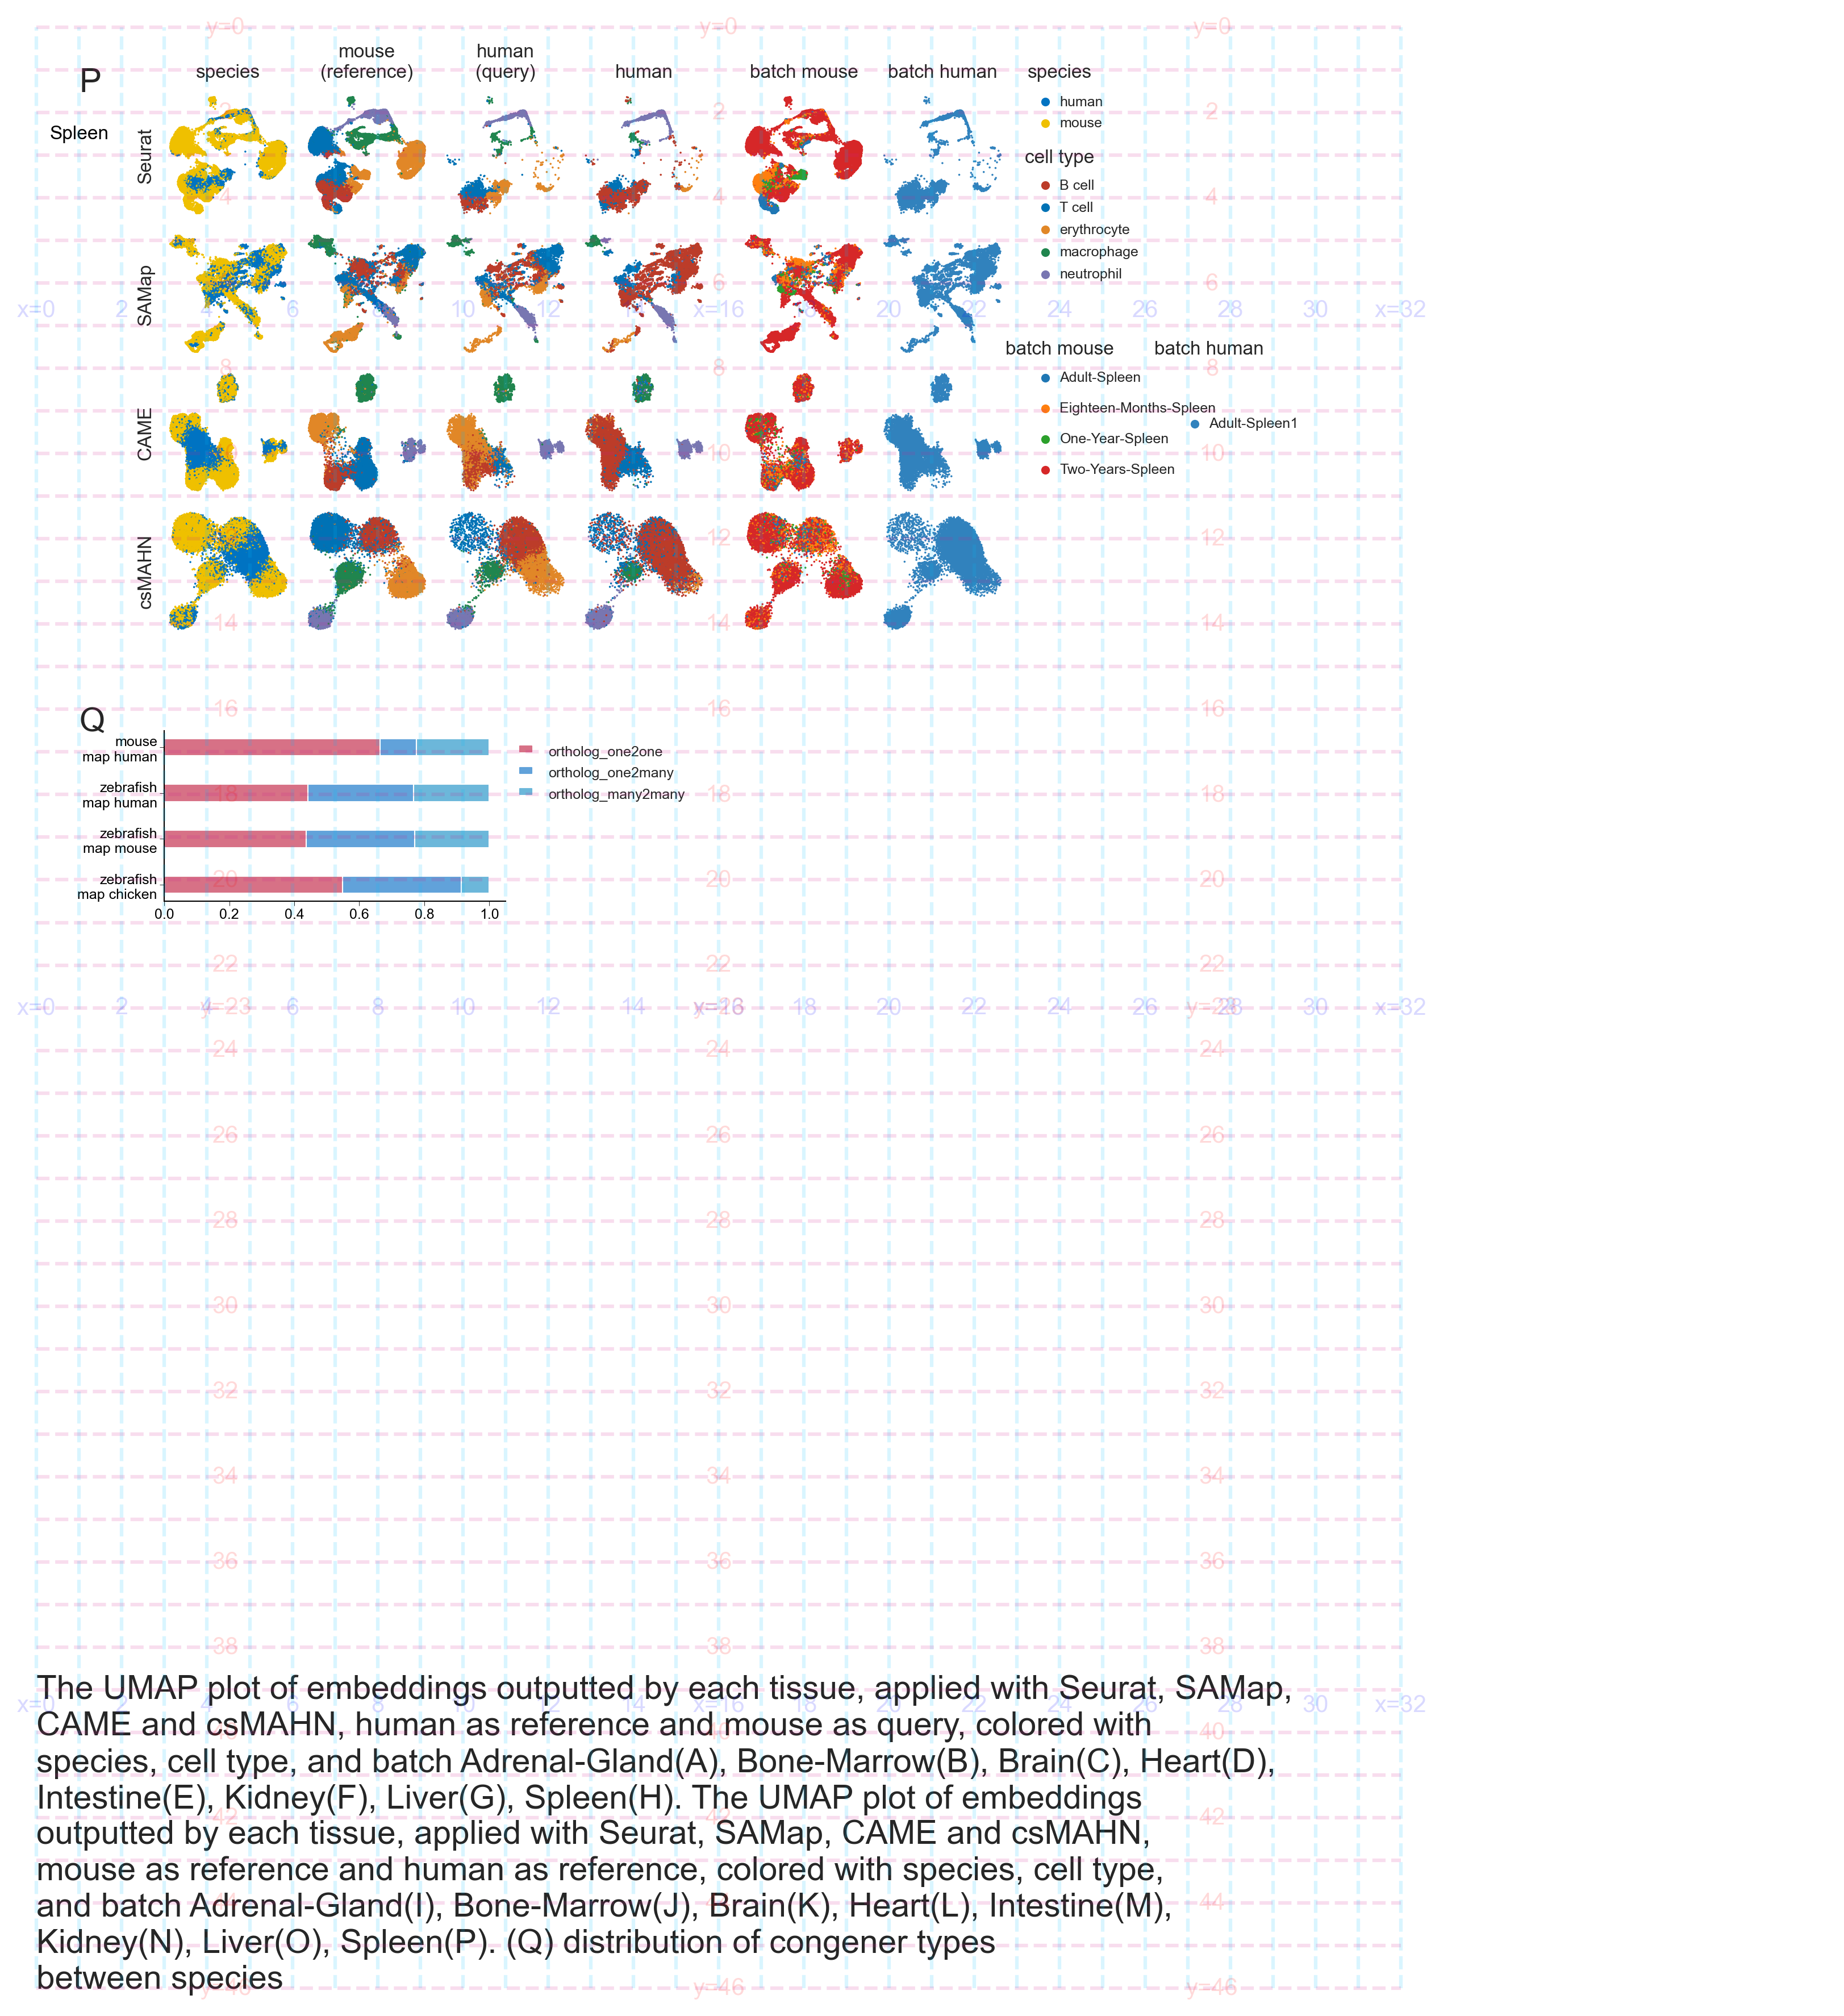

In [12]:
# plt.close("all")
# a4p = pl.figure.A4Page()
y = 16.5
with Block("homo_type", context=dict(x=3, y=y)) as context:
    df_plot = ppara_data['homo_type_count']
    cmap = ppara_cmap['homo_type']
    para = dict(gap_between_group=.8, width_one_bar=1,
                width_ratio=.3, to_horizontal=True)
    ax = a4p.add_ax(context.x, context.y, 8, 4, rc=pl.rc_frame)
    for _, (k) in enumerate(
        df_plot.filter(
            regex='^(?!bottom_)').columns):
        pl.bar(ax, df_plot, key_height=k, cmap=cmap,
               bottom='bottom_{}'.format(k), group_counts=0,
               ngroup=0, **para)
    pl.bar_add_ticks(ax, df_plot, group_counts=0, offset=.5,
                     fontdict=dict(fontsize=6), **para)

    ax = a4p.add_ax(context.x+8, context.y, 2, 2)
    pl.cmap.show(cmap, marker=mpl.path.Path(np.array([[0, 0], [2, 0], [2, 1], [
                 0, 1], [0, 0]]), np.array([1, 2, 2, 2, 79])), size=100, ax=ax)

    a4p.add_text_with_ax(a4p.add_ax(context.x-2, context.y), chr(65+16))
    del df_plot, cmap, para
with Block("note"):
    text = "\
The UMAP plot of embeddings outputted by each tissue, applied with Seurat, SAMap, CAME and csMAHN, \
human as reference and mouse as query, colored with species, cell type, and batch \
Adrenal-Gland(A), Bone-Marrow(B), Brain(C), Heart(D), Intestine(E), Kidney(F), Liver(G), Spleen(H). \
The UMAP plot of embeddings outputted by each tissue, applied with Seurat, SAMap, CAME and csMAHN, \
mouse as reference and human as reference, colored with species, cell type, and batch \
Adrenal-Gland(I), Bone-Marrow(J), Brain(K), Heart(L), Intestine(M), Kidney(N), Liver(O), Spleen(P). \
(Q) distribution of congener types between species \
"
    text = pl.tl_str_next_line(text, 75, ' ')
    a4p.add_text_with_ax(a4p.add_ax(0, 45, 42), text, 0, 0)
    print("{1}\n{0}\n{1}".format(text, '*'*75))
    del text

a4p.save_as_pdf(p_pdf.joinpath('healthy_supp_item_5.pdf'))
a4p.add_grid()
a4p.fig

In [13]:
with Block("merge and delete healthy_supp_item"):
    data_file = ut.df.iter_dir(
        p_pdf, path_match='*healthy_supp_item_*.pdf')
    data_file['id'] = data_file['name'].str.extract(
        "healthy_supp_item_(\\d+).pdf", expand=False).astype(int)
    data_file = data_file.sort_values('id').reset_index(drop=True)
    display(data_file)
    pdf2_merge(data_file['path'], 'healthy_supp.pdf', p_pdf)

    # data_file['path'].apply(rm_rf)
    # print('[delete] healthy_supp_item_*.pdf')

,path,name,id
0,/public/workspace/licanchengup/link/res_publis...,healthy_supp_item_0.pdf,0
1,/public/workspace/licanchengup/link/res_publis...,healthy_supp_item_1.pdf,1
2,/public/workspace/licanchengup/link/res_publis...,healthy_supp_item_2.pdf,2
3,/public/workspace/licanchengup/link/res_publis...,healthy_supp_item_3.pdf,3
4,/public/workspace/licanchengup/link/res_publis...,healthy_supp_item_4.pdf,4
5,/public/workspace/licanchengup/link/res_publis...,healthy_supp_item_5.pdf,5


[out][pdf] healthy_supp.pdf


# finish

In [14]:
print('\n[finish]\n'.center(100, '-'))

---------------------------------------------
[finish]
---------------------------------------------
